In [ ]:
!pip install box2d-py

In [ ]:
!pip install pyvirtualdisplay


In [ ]:
!pip install xvfbwrapper


In [ ]:
!pip install 'gym[atari]'


In [ ]:
!pip install gym==0.21


In [ ]:
!pip install stable-baselines3 --upgrade

In [ ]:
!pip install box2d-py
!pip install gym


In [38]:
!pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.0/841.0 kB 2.9 MB/s eta 0:00:0000:0100:01


In [1]:
import torch 
import gym
from gym.envs.box2d.lunar_lander import LunarLanderContinuous

# Define the policy network
class Policy(torch.nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc = torch.nn.Linear(8, 4)
    
    def forward(self, x):
        x = torch.relu(self.fc(x))
        return x

# Function to preprocess the observation
def preprocess(observation):
    return torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

# Create the environment
env = LunarLanderContinuous()

# Create the policy network
policy = Policy()


In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.action_var = torch.full((output_size,), 0.1)
        self.action_var.requires_grad = True

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

    def act(self, state):
        state = torch.from_numpy(state).float()
        state = state.unsqueeze(0)  # Add batch dimension
        action_mean = self.forward(state)
        cov_matrix = torch.diag(self.action_var).unsqueeze(dim=0)
        action_distribution = Normal(action_mean, cov_matrix)
        action = action_distribution.sample()
        action_log_prob = action_distribution.log_prob(action)
        return action.detach().numpy().flatten(), action_log_prob.detach()

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

def update_policy(optimizer, action_log_probs, rewards):
    discounted_rewards = calculate_discounted_rewards(rewards)
    discounted_rewards = torch.tensor(discounted_rewards)  # Convert to tensor
    discounted_rewards -= torch.mean(discounted_rewards)
    discounted_rewards /= torch.std(discounted_rewards)

    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.stack(policy_loss).sum().detach()  # Detach the tensor and sum

    optimizer.zero_grad()
    policy_loss.requires_grad = True  # Set requires_grad flag to True
    policy_loss.backward()
    optimizer.step()

# Set up environment
env = gym.make("MountainCarContinuous-v0")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train policy network
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)

env.close()


Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900


In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import pickle

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.action_var = torch.full((output_size,), 0.1)
        self.action_var.requires_grad = True

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

    def act(self, state):
        state = torch.from_numpy(state).float()
        state = state.unsqueeze(0)  # Add batch dimension
        action_mean = self.forward(state)
        cov_matrix = torch.diag(self.action_var).unsqueeze(dim=0)
        action_distribution = Normal(action_mean, cov_matrix)
        action = action_distribution.sample()
        action_log_prob = action_distribution.log_prob(action)
        return action.detach().numpy().flatten(), action_log_prob.detach()

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

def update_policy(optimizer, action_log_probs, rewards):
    discounted_rewards = calculate_discounted_rewards(rewards)
    discounted_rewards = torch.tensor(discounted_rewards)  # Convert to tensor
    discounted_rewards -= torch.mean(discounted_rewards)
    discounted_rewards /= torch.std(discounted_rewards)

    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.stack(policy_loss).sum().detach()  # Detach the tensor and sum

    optimizer.zero_grad()
    policy_loss.requires_grad = True  # Set requires_grad flag to True
    policy_loss.backward()
    optimizer.step()

# Set up environment
env = gym.make("MountainCarContinuous-v0")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = None

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        if episode % 500 == 0:
            pickle.dump(policy, open("policy_model.p", "wb"))

# Continue training policy network
for episode in range(num_episodes, 2*num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        if episode % 500 == 0:
            pickle.dump(policy, open("policy_model.p", "wb"))

env.close()


Episode: 0
Episode reward: -1.3131929686165242
Running mean reward: -1.3131929686165242
Episode: 100
Episode reward: -128.6321633058997
Running mean reward: -2.586382671989356
Episode: 200
Episode reward: -127.75877968579552
Running mean reward: -3.8381066421274177
Episode: 300
Episode reward: -128.96515185037305
Running mean reward: -5.089377094209874
Episode: 400
Episode reward: -128.9889248535108
Running mean reward: -6.328372571802884
Episode: 500
Episode reward: -128.6306236862712
Running mean reward: -7.551395082947567
Episode: 600
Episode reward: -129.0310552587112
Running mean reward: -8.766191684705204
Episode: 700
Episode reward: -129.43150324220554
Running mean reward: -9.972844800280207
Episode: 800
Episode reward: -128.16172812964814
Running mean reward: -11.154733633573887
Episode: 900
Episode reward: -128.38184864402135
Running mean reward: -12.327004783678362
Episode: 1000
Episode reward: -129.32334614243194
Running mean reward: -13.496968197265899
Episode: 1100
Episode

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import pickle

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.action_var = torch.full((output_size,), 0.1)
        self.action_var.requires_grad = True

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

    def act(self, state):
        state = torch.from_numpy(state).float()
        state = state.unsqueeze(0)  # Add batch dimension
        action_mean = self.forward(state)
        cov_matrix = torch.diag(self.action_var).unsqueeze(dim=0)
        action_distribution = Normal(action_mean, cov_matrix)
        action = action_distribution.sample()
        action_log_prob = action_distribution.log_prob(action)
        return action.detach().numpy().flatten(), action_log_prob.detach()

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

def update_policy(optimizer, action_log_probs, rewards):
    discounted_rewards = calculate_discounted_rewards(rewards)
    discounted_rewards = torch.tensor(discounted_rewards)  # Convert to tensor
    discounted_rewards -= torch.mean(discounted_rewards)
    discounted_rewards /= torch.std(discounted_rewards)

    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.stack(policy_loss).sum().detach()  # Detach the tensor and sum

    optimizer.zero_grad()
    policy_loss.requires_grad = True  # Set requires_grad flag to True
    policy_loss.backward()
    optimizer.step()

# Set up environment
env = gym.make("MountainCarContinuous-v0")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = None

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        if episode % 500 == 0:                         
            pickle.dump(policy, open("policy_model.p", "wb"))

# Continue training policy network
for episode in range(num_episodes, 2 * num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        if episode % 500 == 0:
            pickle.dump(policy, open("policy_model.p", "wb"))

env.close()

def play_game(env, model):
    observation, _ = env.reset()

    frames = []
    cumulated_reward = 0

    prev_x = None  # used in computing the difference frame

    for t in range(1000):
        frames.append(env.render())
        action, prev_x = model_step(model, observation, prev_x)
        observation, reward, done, info, _ = env.step(action)
        cumulated_reward += reward
        if done:
            print("Episode finished after {} timesteps, accumulated reward = {}".format(t + 1, cumulated_reward))
            break
    print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
    env.close()
    return frames

def model_step(model, observation, prev_x):
    processed_observation = preprocess(observation)
    x = processed_observation - prev_x if prev_x is not None else np.zeros(processed_observation.shape)
    prev_x = processed_observation
    action, _ = model.act(x)
    return action, prev_x

def preprocess(observation):
    # Modify the preprocessing step according to your needs
    return observation

# Play the game using the trained policy
model = pickle.load(open("policy_model.p", "rb"))
frames = play_game(env, model)

# Display the frames as a video
for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())


Episode: 0
Episode reward: -4.553510936759021
Running mean reward: -4.553510936759021
Episode: 100
Episode reward: -460.69996009474636
Running mean reward: -9.114975428338894
Episode: 200
Episode reward: -461.82510607477656
Running mean reward: -13.642076734803272
Episode: 300
Episode reward: -458.5810162471544
Running mean reward: -18.091466129926783
Episode: 400
Episode reward: -457.75896675458176
Running mean reward: -22.488141136173333
Episode: 500
Episode reward: -460.61234778905435
Running mean reward: -26.869383202702146
Episode: 600
Episode reward: -460.467127930874
Running mean reward: -31.205360649983863
Episode: 700
Episode reward: -461.0713728803938
Running mean reward: -35.504020772287966
Episode: 800
Episode reward: -457.90230256727284
Running mean reward: -39.72800359023781
Episode: 900
Episode reward: -459.6691495698153
Running mean reward: -43.92741505003359
Episode: 1000
Episode reward: -458.3076548477918
Running mean reward: -48.07121744801117
Episode: 1100
Episode r

In [ ]:
import matplotlib.pyplot as plt
from IPython import display

def print_frames(frames):
    for i, frame in enumerate(frames):
        plt.imshow(frame)
        plt.axis('off')
        display.clear_output(wait=True)
        display.display(plt.gcf())

# Play the game using the trained policy
model = pickle.load(open("policy_model.p", "rb"))
frames = play_game(env, model)

# Display the frames as a video
print_frames(frames)


Episode: 0
Episode reward: -2.28883864983427
Running mean reward: -2.28883864983427
Episode: 100
Episode reward: -221.85866980624292
Running mean reward: -4.484536961398357
Episode: 200
Episode reward: -222.75740610790533
Running mean reward: -6.667265652863426
Episode: 300
Episode reward: -221.00578239261446
Running mean reward: -8.810650820260935
Episode: 400
Episode reward: -222.60338787295439
Running mean reward: -10.94857819078787
Episode: 500
Episode reward: -221.53630490100628
Running mean reward: -13.054455457890054
Episode: 600
Episode reward: -222.29873518014097
Running mean reward: -15.146898255112562
Episode: 700
Episode reward: -224.13186182136053
Running mean reward: -17.236747890775042
Episode: 800
Episode reward: -222.246151551902
Running mean reward: -19.28684192738631
Episode: 900
Episode reward: -222.03850164984843
Running mean reward: -21.314358524610928
Episode: 0
Episode reward: -2.233502135425822
Running mean reward: -0.022335021354258223
Episode: 100
Episode rew

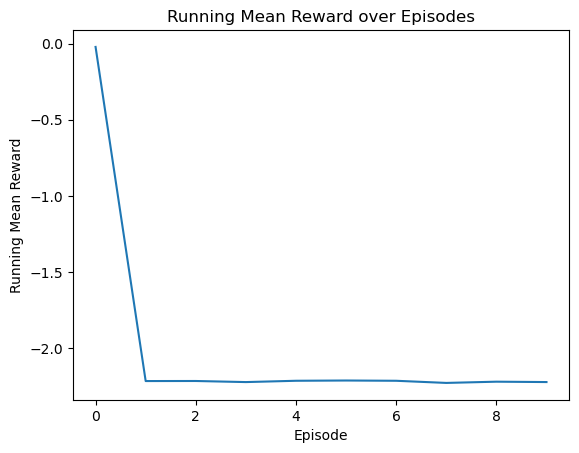

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.action_var = torch.full((output_size,), 0.1)
        self.action_var.requires_grad = True

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

    def act(self, state):
        state = torch.from_numpy(state).float()
        state = state.unsqueeze(0)  # Add batch dimension
        action_mean = self.forward(state)
        cov_matrix = torch.diag(self.action_var).unsqueeze(dim=0)
        action_distribution = Normal(action_mean, cov_matrix)
        action = action_distribution.sample()
        action_log_prob = action_distribution.log_prob(action)
        return action.detach().numpy().flatten(), action_log_prob.detach()

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

def update_policy(optimizer, action_log_probs, rewards):
    discounted_rewards = calculate_discounted_rewards(rewards)
    discounted_rewards = torch.tensor(discounted_rewards)  # Convert to tensor
    discounted_rewards -= torch.mean(discounted_rewards)
    discounted_rewards /= torch.std(discounted_rewards)

    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.stack(policy_loss).sum().detach()  # Detach the tensor and sum

    optimizer.zero_grad()
    policy_loss.requires_grad = True  # Set requires_grad flag to True
    policy_loss.backward()
    optimizer.step()

# # Set up environment
env = gym.make("MountainCarContinuous-v0")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = None
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        episode_rewards.append(running_reward)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = 0
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum / 100  # Calculate running mean reward
        print("Running mean reward:", running_reward)
        reward_sum = 0
        episode_rewards.append(running_reward)

# Plot rewards
plt.plot(episode_rewards)
plt.title('Running Mean Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Running Mean Reward')
plt.show()


# # Plot
# # Plot rewards
# plt.plot(episode_rewards)
# plt.title('Total Reward over Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.show()

# # Continue training policy network
# for episode in range(num_episodes, 2*num_episodes):
#     state = env.reset()
#     done = False
#     rewards = []
#     action_log_probs = []

#     while not done:
#         action, action_log_prob = policy.act(state)
#         next_state, reward, done, _ = env.step(action)
#         rewards.append(reward)
#         action_log_probs.append(action_log_prob)
#         state = next_state
#         reward_sum += reward

#     update_policy(optimizer, action_log_probs, rewards)

#     if episode % 100 == 0:
#         print("Episode:", episode)
#         print("Episode reward:", reward_sum)
#         running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
#         print("Running mean reward:", running_reward)
#         reward_sum = 0
#         episode_rewards.append(running_reward)

# # Plot rewards
# plt.plot(episode_rewards)
# plt.title('Total Reward over Episodes')
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
# plt.show()

# env.close()



Episode: 0
Episode reward: -11.523980466906927
Running mean reward: -11.523980466906927
Episode: 100
Episode reward: -1158.4686528559719
Running mean reward: -22.993427190797576
Episode: 200
Episode reward: -1162.0948854004134
Running mean reward: -34.38444177289374
Episode: 300
Episode reward: -1161.7711421431554
Running mean reward: -45.65830877659636
Episode: 400
Episode reward: -1163.3337079822415
Running mean reward: -56.83506276865281
Episode: 500
Episode reward: -1159.2444231566876
Running mean reward: -67.85915637253316
Episode: 600
Episode reward: -1163.4103716428044
Running mean reward: -78.81466852523587
Episode: 700
Episode reward: -1165.683462756124
Running mean reward: -89.68335646754475
Episode: 800
Episode reward: -1160.0928478814894
Running mean reward: -100.3874513816842
Episode: 900
Episode reward: -1160.3405819815441
Running mean reward: -110.9869826876828


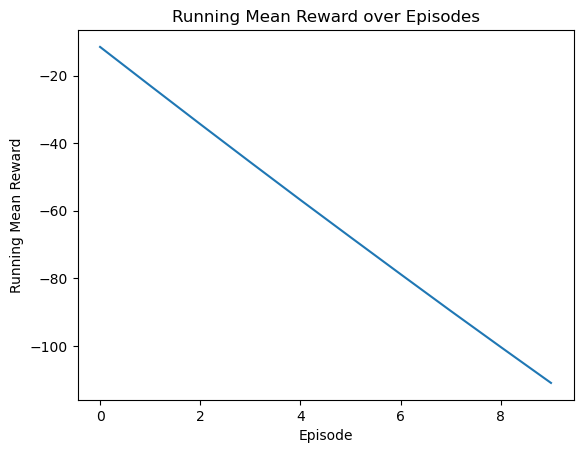

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

        self.action_var = torch.full((output_size,), 0.1)
        self.action_var.requires_grad = True

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

    def act(self, state):
        state = torch.from_numpy(state).float()
        state = state.unsqueeze(0)  # Add batch dimension
        action_mean = self.forward(state)
        cov_matrix = torch.diag(self.action_var).unsqueeze(dim=0)
        action_distribution = Normal(action_mean, cov_matrix)
        action = action_distribution.sample()
        action_log_prob = action_distribution.log_prob(action)
        return action.detach().numpy().flatten(), action_log_prob.detach()

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

def update_policy(optimizer, action_log_probs, rewards):
    discounted_rewards = calculate_discounted_rewards(rewards)
    discounted_rewards = torch.tensor(discounted_rewards)  # Convert to tensor
    discounted_rewards -= torch.mean(discounted_rewards)
    discounted_rewards /= torch.std(discounted_rewards)

    policy_loss = []
    for log_prob, reward in zip(action_log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.stack(policy_loss).sum().detach()  # Detach the tensor and sum

    optimizer.zero_grad()
    policy_loss.requires_grad = True  # Set requires_grad flag to True
    policy_loss.backward()
    optimizer.step()

# Set up environment
env = gym.make("MountainCarContinuous-v0")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = None
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []
    action_log_probs = []

    while not done:
        action, action_log_prob = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        action_log_probs.append(action_log_prob)
        state = next_state
        reward_sum += reward

    update_policy(optimizer, action_log_probs, rewards)

    if episode % 100 == 0:
        print("Episode:", episode)
        print("Episode reward:", reward_sum)
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print("Running mean reward:", running_reward)
        reward_sum = 0
        episode_rewards.append(running_reward)

# Plot rewards
plt.plot(episode_rewards)
# Plot rewards
plt.title('Running Mean Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Running Mean Reward')
plt.show()


Episode: 0, Total Reward: 17.0, Running Reward: 0.17
Episode: 100, Total Reward: 35.0, Running Reward: 14.017932702031418
Episode: 200, Total Reward: 39.0, Running Reward: 20.23850787863404
Episode: 300, Total Reward: 16.0, Running Reward: 19.89416758857546
Episode: 400, Total Reward: 10.0, Running Reward: 20.05738563354701
Episode: 500, Total Reward: 14.0, Running Reward: 19.60786919688532
Episode: 600, Total Reward: 11.0, Running Reward: 19.724805166640795
Episode: 700, Total Reward: 11.0, Running Reward: 19.599129661536686
Episode: 800, Total Reward: 13.0, Running Reward: 19.14525952255776
Episode: 900, Total Reward: 24.0, Running Reward: 19.57268976172941


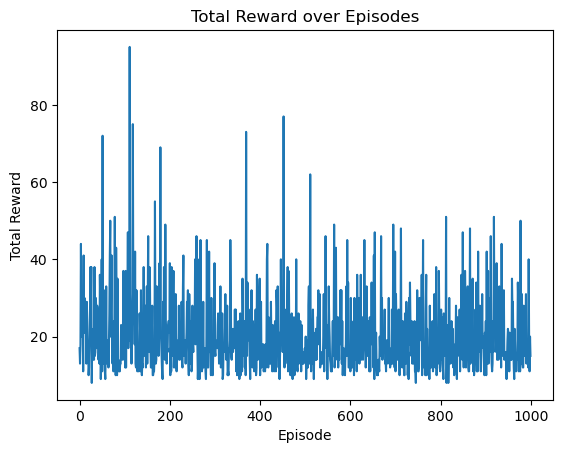

In [4]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Set up environment
env = gym.make("CartPole-v1")
env.seed(0)

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
policy = Policy(input_size, output_size)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train policy network
num_episodes = 1000
episode_rewards = []
running_reward = 0
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Select action
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = policy(state)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()

        # Take action
        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward

        # Update state
        state = next_state

    # Update policy
    optimizer.zero_grad()
    episode_rewards.append(total_reward)
    running_reward = 0.99 * running_reward + 0.01 * total_reward
    loss = -action_dist.log_prob(action) * total_reward
    loss.backward()
    optimizer.step()

    # Print progress
    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {total_reward}, Running Reward: {running_reward}")

# Plot rewards
plt.plot(episode_rewards)
plt.title('Total Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

env.close()


In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define policy network
class Policy(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

# Define function to calculate discounted rewards
def calculate_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_reward = 0
    for reward in reversed(rewards):
        running_reward = reward + gamma * running_reward
        discounted_rewards.insert(0, running_reward)
    return discounted_rewards

# Set up environment
env = gym.make('BipedalWalker-v3')

# Set up policy network
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
policy = Policy(input_size, output_size)

# Set up optimizer
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train policy network
num_episodes = 1000
reward_sum = 0
running_reward = None
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    rewards = []

    while not done:
        state_tensor = torch.from_numpy(state).float()
        action = policy(state_tensor)
        action = action.detach().numpy()

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        state = next_state
        reward_sum += reward

    discounted_rewards = calculate_discounted_rewards(rewards)

    optimizer.zero_grad()

    for i, reward in enumerate(discounted_rewards):
        state_tensor = torch.from_numpy(state).float()
        action = policy(state_tensor)
        loss = -action * reward
        loss.backward()

    optimizer.step()

    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {reward_sum}, Running Reward: {running_reward}")
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        reward_sum = 0
        episode_rewards.append(running_reward)

# Plot rewards
plt.plot(episode_rewards)
plt.title('Total Rewards as a Function of Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()
